In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('Nat_Gas.csv')

In [3]:
df.shape

(48, 2)

In [5]:
df.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [7]:
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [8]:
df.columns

Index(['Dates', 'Prices'], dtype='object')

In [10]:
#Convert 'Date' to datetime
df['Dates'] = pd.to_datetime(df['Dates'])

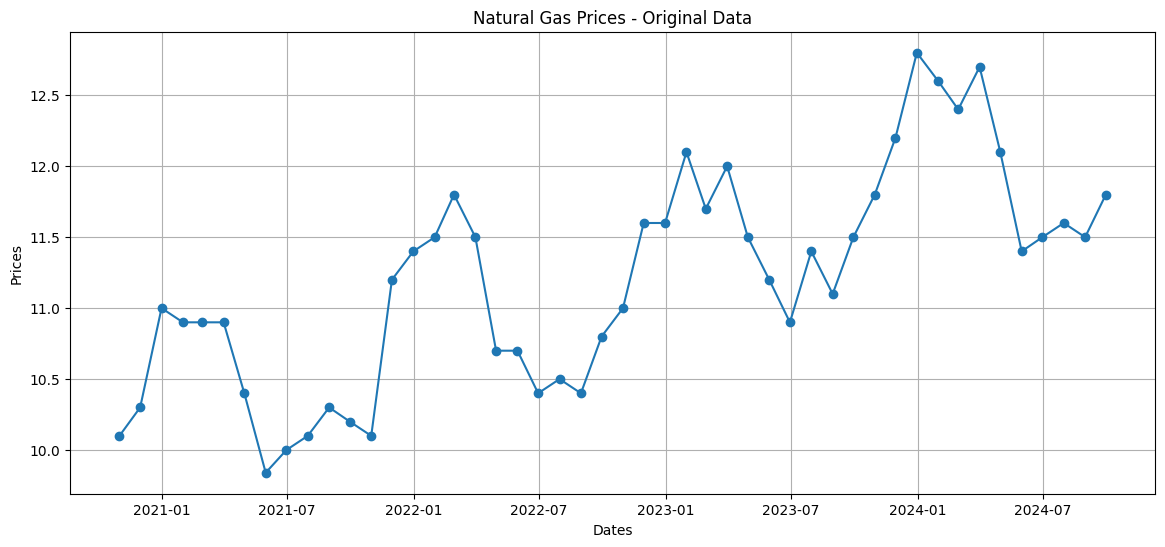

In [12]:
#Visualize the original data

plt.figure(figsize=(14,6))
plt.plot(df['Dates'], df['Prices'], marker='o')
plt.title('Natural Gas Prices - Original Data')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.grid(True)
plt.show()

In [13]:
#Fill missing dates (interpolation)

# Create a complete date range from min to max date
full_date_range = pd.date_range(start=df['Dates'].min(), end=df['Dates'].max())

# Reindex the DataFrame to fill missing dates
df_full = df.set_index('Dates').reindex(full_date_range)
df_full.index.name = 'Dates'

# Interpolate missing prices
df_full['Prices'] = df_full['Prices'].interpolate(method='linear')

# Reset index
df_full = df_full.reset_index()

In [14]:
#Encode dates numerically
df_full['date_ordinal'] = df_full['Dates'].map(pd.Timestamp.toordinal)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


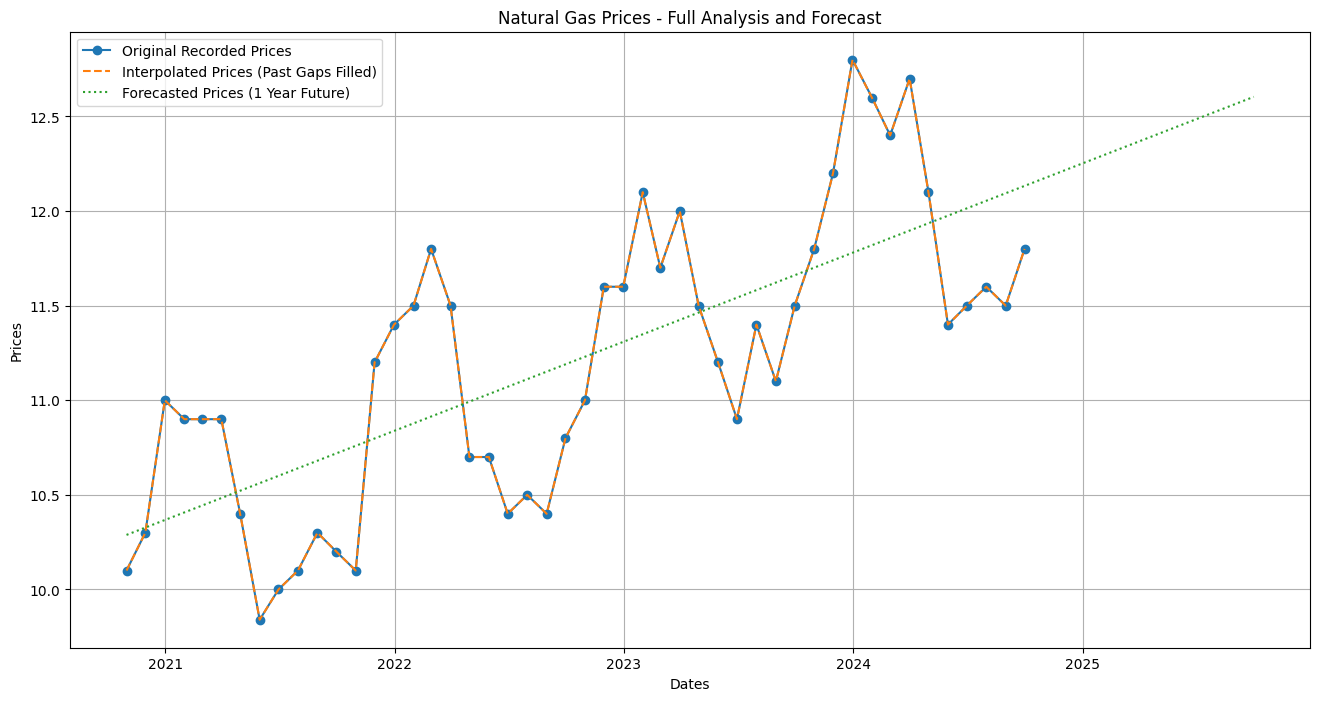

In [22]:
from sklearn.linear_model import LinearRegression

# Train Linear Regression model
X = df_full[['date_ordinal']]
y = df_full['Prices']

model = LinearRegression()
model.fit(X, y)

# Predict past prices for all known dates (already done with interpolation)
# Now predict future prices (1 year)

last_known_date = df_full['Dates'].max()
future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=365)

# Combine historical + future dates
all_dates = pd.concat([
    df_full['Dates'],
    pd.Series(future_dates)
])

# Encode all dates numerically
all_dates_ordinal = all_dates.map(pd.Timestamp.toordinal).values.reshape(-1, 1)

# Predict prices
predicted_prices = model.predict(all_dates_ordinal)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Dates': all_dates.values,
    'Predicted_Price': predicted_prices
})

# Plot the results
plt.figure(figsize=(16,8))
plt.plot(df['Dates'], df['Prices'], label='Original Recorded Prices', marker='o')
plt.plot(df_full['Dates'], df_full['Prices'], label='Interpolated Prices (Past Gaps Filled)', linestyle='--')
plt.plot(forecast_df['Dates'], forecast_df['Predicted_Price'], label='Forecasted Prices (1 Year Future)', linestyle=':')
plt.title('Natural Gas Prices - Full Analysis and Forecast')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# FUNCTION to predict price with custom date limits
def estimate_gas_price(input_date_str):
    try:
        # Convert input string to datetime
        input_date = pd.to_datetime(input_date_str)

        # Define dataset start and end limits
        dataset_start_date = pd.to_datetime('2020-10-31')
        dataset_end_date = pd.to_datetime('2024-09-30')

        # Define allowed future prediction window
        future_start_date = pd.to_datetime('2024-10-01')
        future_end_date = pd.to_datetime('2025-09-30')

        # Check if input date falls in valid ranges
        if (dataset_start_date <= input_date <= dataset_end_date) or (future_start_date <= input_date <= future_end_date):
            # Good date, predict price
            input_ordinal = np.array([[input_date.toordinal()]])
            predicted_price = model.predict(input_ordinal)
            return predicted_price[0]
        else:
            print("Date is outside the allowed prediction window (Oct 31, 2020 - Sept 30, 2025).")
            return None

    except Exception as e:
        print(f"Error processing the date: {e}")
        return None

# Take user input
user_date = input("Enter a date (YYYY-MM-DD) to estimate gas price: ")

# Estimate and display result
predicted_price = estimate_gas_price(user_date)

if predicted_price is not None:
    print(f"Estimated gas purchase price on {user_date}: ${predicted_price:.2f}")
else:
    print("Could not estimate the price. Please check your input.")


Enter a date (YYYY-MM-DD) to estimate gas price: 2025-04-07
Estimated gas purchase price on 2025-04-07: $12.38


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
